# Milestone 4 : Analyse de la « feature importance » globale et locale
## Notebook partie « Feature importance
https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html

In [1]:
%load_ext autoreload
%autoreload


import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from scripts import *
from scripts_utils import * 

# check pycaret version
import pycaret
print('PyCaret: %s' % pycaret.__version__)
from pycaret.classification import *

import pickle



PyCaret: 2.2.0


In [2]:
load_config('my_pycaret_model.pkl') 
X_train_pycaret = get_config('X_train')
X_test_pycaret = get_config('X_test')
y_train_pycaret = get_config('y_train')

y_test_pycaret = pd.DataFrame(get_config('y_test'))
# data_unseen =  pd.DataFrame(get_config('X_test'))

X_train_pycaret.shape, X_test_pycaret.shape, y_train_pycaret.shape, y_test_pycaret.shape



((172203, 756), (73802, 756), (172203,), (73802, 1))

Le modèle optimale est le LGBMClassifier avec le paramètre `class_weight="balanced"` et un seuil de 0.5

In [3]:
model = LGBMClassifier(bagging_fraction=0.5, bagging_freq=4, class_weight='balanced',
               feature_fraction=0.8, learning_rate=0.05, min_child_samples=46,
               min_split_gain=0.5, n_estimators=220, num_leaves=80,
               random_state=2059, reg_alpha=0.7, reg_lambda=0.01)

model.fit(X_train_pycaret, y_train_pycaret)

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


LGBMClassifier(bagging_fraction=0.5, bagging_freq=4, class_weight='balanced',
               feature_fraction=0.8, learning_rate=0.05, min_child_samples=46,
               min_split_gain=0.5, n_estimators=220, num_leaves=80,
               random_state=2059, reg_alpha=0.7, reg_lambda=0.01)

In [4]:

print(model.score(X_test_pycaret, y_test_pycaret))

filename = r'../notebook/model.pkl'
pickle.dump(model, open(filename, 'wb'))

0.7790032790439283


In [5]:
# load the model from disk
import pickle
filename = r'../notebook/model.pkl'
model = pickle.load(open(filename, 'rb'))
result = model.score(X_test_pycaret, y_test_pycaret)
print(result)

0.7790032790439283


## Importance des variables

Text(0.5, 1.0, 'Features Importance')

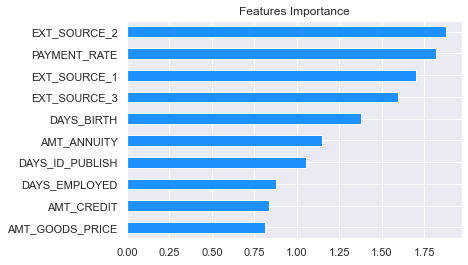

In [6]:
import seaborn as sns
sns.set(style = 'darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline

Importance_df = pd.DataFrame((model.feature_importances_ / sum(model.feature_importances_))*100, index=X_test_pycaret.columns, columns=['Features Importance'])
Importance_df = Importance_df.sort_values(by = 'Features Importance')[-10::]
ax = Importance_df.plot.barh(color='dodgerblue', legend=None)
plt.title('Features Importance')

In [7]:
import shap
import pickle
shap.initjs()

explainer = shap.TreeExplainer(model, 
                               model_output = 'probability',
                               data = X_train_pycaret.sample(3),
                               feature_dependence='independent')

shap_values = explainer.shap_values(X_test_pycaret, y_test_pycaret)

100%|===================| 73525/73802 [01:00<00:00]        

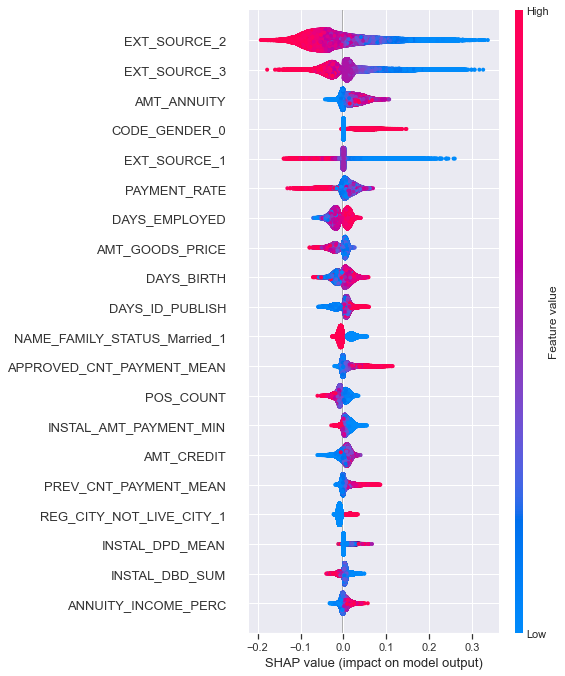

In [8]:
#shap.summary_plot(shap_values, X_test_pycaret, max_display=20)
shap.summary_plot(shap_values, X_test_pycaret)

In [9]:
# find the chart plot for one customer only
#i=1
#shap.force_plot(explainer.expected_value, shap_values[i], X_train_pycaret.iloc[i])

def shap_plot(i):
    #predict_model(loaded_model)
    #print(loaded_model.predict_proba(X_test_pycaret.iloc[i:i+1]).round(2))
    print('True class :', y_test_pycaret.iloc[i])
    return(shap.force_plot(explainer.expected_value, shap_values[i], X_train_pycaret.iloc[i]))



In [10]:
shap_plot(4)

True class : TARGET    0
Name: 381804, dtype: int64


Passing a matrix of SHAP values to the bar plot function creates a global feature importance plot, where the global importance of each feature is taken to be the mean absolute value for that feature over all the given samples.

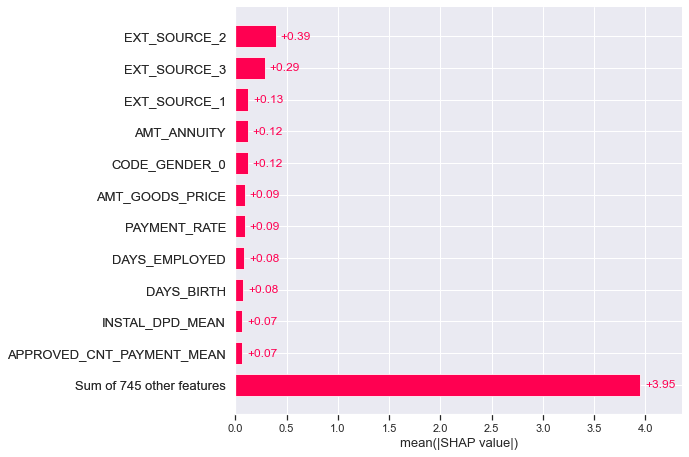

In [11]:
# compute SHAP values
explainer = shap.Explainer(model, X_train_pycaret.sample(100))
shap_values = explainer(X_train_pycaret.sample(100))
shap.plots.bar(shap_values, max_display=12)

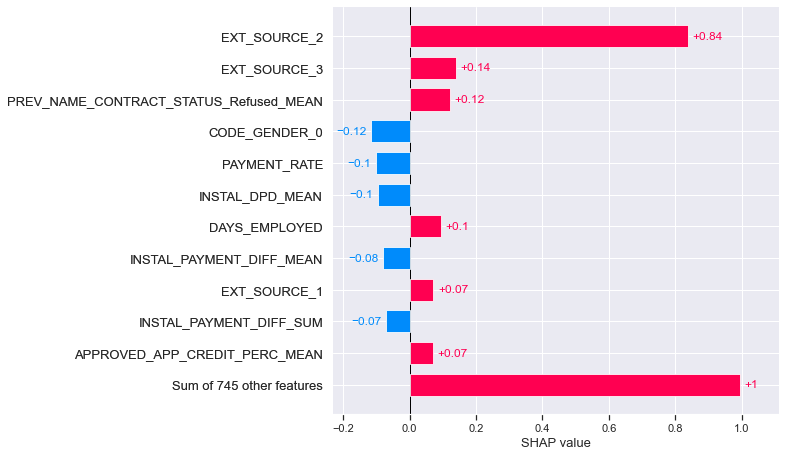

In [12]:
i=10
shap.plots.bar(shap_values[10], max_display=12)

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. Another way to visualize the same explanation is to use a force plot (these are introduced in our Nature BME paper):